In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
matplotlib.rcParams['font.size']=18
matplotlib.rcParams['xtick.labelsize']=18
matplotlib.rcParams['ytick.labelsize']=18


import numpy as np
import pandas as pd
import requests
import urllib.request
from bs4 import BeautifulSoup
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
from sklearn import metrics

warnings.filterwarnings('ignore')


from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score


In [2]:
def pythag(pf,pa,exp=11.5):
    return (pf**exp)/(pa**exp+pf**exp)

def pythagGame(df_game,exp=11.5):
    p={}
    for iteam in np.arange(1,3):
        pf = df_game['AdjO_'+str(iteam)]
        pa = df_game['AdjD_'+str(iteam)]
        p[str(iteam)] = pythag(pf,pa,exp)
        
    return p['1']*(1.-p['2'])/(p['1']+p['2']-2.*p['1']*p['2'])
    

In [3]:
teamType=pd.read_csv('data/team_type.csv')
teamTypeDict={}
for r in teamType.values:
    teamTypeDict[r[0]]=r[1]

In [4]:
res=[]
dfAll=pd.DataFrame()
for year in np.arange(2017,2003,-1):
    df=pd.read_csv('data/games/tourn_games_'+str(year)+'.csv',index_col=0)
    dfAll=dfAll.append(df,ignore_index=True)


df2=dfAll.copy()
index=df2.keys()
index
df2.columns=[indx.replace('_1','_xx').replace('_2','_1').replace('_xx','_2') for indx in index]
df2.outcome=1-df2.outcome

dfAll=(df2.append(dfAll))

In [5]:
dropLabels=['School_1','Conf_1','wpct_1','Rank_1','WL_1','sched_url_1', 'name_1', 'wpct_1','TmPts_1', 'OppPts_1',\
            'School_2','Conf_2','wpct_2','Rank_2','WL_2','sched_url_2', 'name_2', 'wpct_2','TmPts_2', 'OppPts_2', 'outcome', 'region']
dropLabels.append('round')

## Regression on scaled inputs

In [6]:
dropLabels=['outcome', 'region']
dropLabels.append('round')
for t12 in ['1', '2']:
    dropLabels.append('School_'+t12)
    dropLabels.append('name_'+t12)
    dropLabels.append('fullName_'+t12)
    dropLabels.append('Conf_'+t12)
    dropLabels.append('wpct_'+t12)
    dropLabels.append('Rank_'+t12)
    dropLabels.append('WL_'+t12)
    dropLabels.append('sched_url_'+t12)
    dropLabels.append('name_'+t12)
    dropLabels.append('TmPts_'+t12)
    dropLabels.append('OppPts_'+t12)
    dropLabels.append('SRS_'+t12)
    dropLabels.append('SOS_'+t12)
#     dropLabels.append('AdjO_'+t12)
#     dropLabels.append('AdjD_'+t12)
#     dropLabels.append('AdjT_'+t12)
#     dropLabels.append('Luck_'+t12)
    

In [7]:
dfClean=dfAll.drop(dropLabels,axis=1).dropna(axis=1)


features12=dfClean.keys()
features=[l.replace('_1','') for l in features12[::2]]
dfNew=pd.DataFrame()
for lab in features:
    dfNew[lab]=dfClean[lab+'_1']-dfClean[lab+'_2']


dfClean=dfNew
features=np.array(sorted(dfClean.columns))

In [18]:
train_test_split?

In [29]:
n_fold = 10
test_size = 0.3


dfClean=dfClean[features]

scaler=StandardScaler().fit(dfClean)
scaled=scaler.transform(dfClean)
X=scaled
# X=dfClean

y=dfAll['outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)


X=X_train
y=y_train

# for c in np.logspace(-4,0,20):
c=0.1
# model = LogisticRegression(C=c,penalty='l2',fit_intercept=True)
c=1
model = LogisticRegression(C=c,penalty='l1',fit_intercept=True)
# model=RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
model.fit(X_train, y_train)

# y_pred=model.predict(X_test)
kfold = model_selection.KFold(n_splits=n_fold, random_state=10)
scoring = 'roc_auc' #['accuracy','precision']
results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
print (c)
print("10-fold cross validation average "+scoring+": %.3f %.3f" % (results.mean(),results.std())) 

y_predPythag=pythagGame(dfAll,exp=13.5)

# print('Accuracy using pythagorean win expectation: %.3f' % ((np.round(y_predPythag)==y_test).sum()/len(y_test)))
print()
print('Pythac ROC AUC: ',roc_auc_score(dfAll['outcome'],y_predPythag))
print('LogReg ROC AUC: ',roc_auc_score(y,model.predict_proba(X)[:,1]))
print()

# res.append([year,results.mean(),(np.round(y_predPythag)==y_test).sum()/len(y_test)])
row=1
print(dfAll.loc[row][['name_1','name_2']].values)
print(model.predict_proba(X)[row,:])
print((model.coef_!=0).sum())

1
10-fold cross validation average roc_auc: 0.856 0.032

Pythac ROC AUC:  0.849305330598
LogReg ROC AUC:  0.864874528413

[['virginia-tech' 'wisconsin']
 ['wisconsin' 'virginia-tech']]
[ 0.65124223  0.34875777]
16


In [239]:
# features=features[np.where(model.coef_!=0)[1]]
# features

[[227  56]
 [ 52 195]]


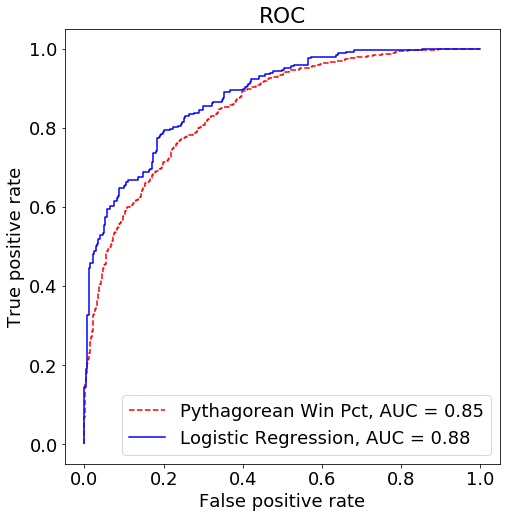

In [30]:
# X_train, X_test, y_train, y_test

print(confusion_matrix(y_test,model.predict(X_test)))

fpr,tpr,thr=roc_curve(dfAll['outcome'],y_predPythag)
plt.plot(fpr,tpr,'r--',label='Pythagorean Win Pct, AUC = '+str(round(roc_auc_score(dfAll['outcome'],y_predPythag),2)))

fpr,tpr,thr=roc_curve(y_test,model.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'b',label='Logistic Regression, AUC = '+str(round(roc_auc_score(y_test,model.predict_proba(X_test)[:,1]),2)))
plt.legend()
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')

roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
ax=plt.gca()
ax.set_aspect(1)

In [ ]:
plt.cm.

Text(0,0.5,'Predicted')

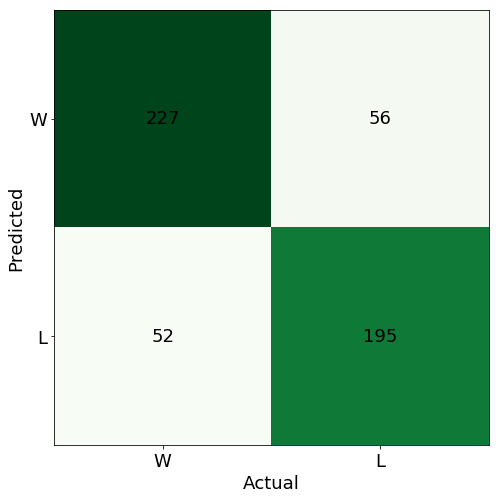

In [49]:
fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
conf_arr=confusion_matrix(y_test,model.predict(X_test))
res = plt.imshow(conf_arr,cmap='Greens')

width, height = conf_arr.shape

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)
alphabet = 'WL'
plt.xticks(range(width), alphabet[:width])
plt.yticks(range(height), alphabet[:height])
plt.xlabel('Actual')
plt.ylabel('Predicted')


[[685 197]
 [197 685]]


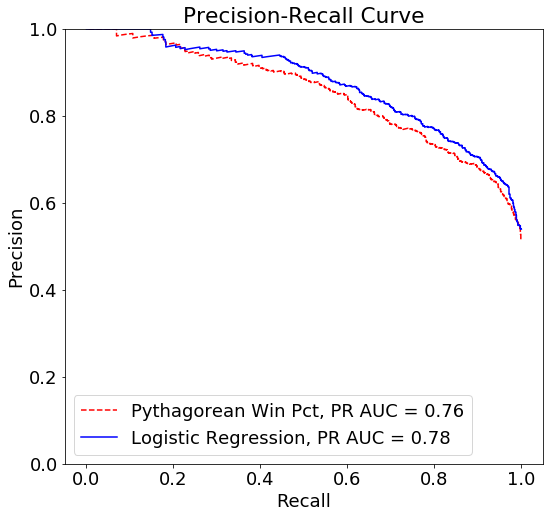

In [241]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,precision_recall_curve, precision_score
print(confusion_matrix(y,model.predict(X)))

precision,recall,thr=precision_recall_curve(y,y_predPythag)
plt.plot(recall,precision,'r--',label='Pythagorean Win Pct, PR AUC = '+str(round(precision_score(y,y_predPythag>0.5),2)))

precision,recall,thr=precision_recall_curve(y,model.predict_proba(X)[:,1])
plt.plot(recall,precision,'b',label='Logistic Regression, PR AUC = '+str(round(precision_score(y,model.predict_proba(X)[:,1]>0.5),2)))
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

roc_auc_score(y,model.predict_proba(X)[:,1])
plt.ylim(0,1)
ax=plt.gca()
ax.set_aspect(1)

In [242]:
import pickle
from sklearn.externals import joblib
joblib.dump(model, 'app/model.pkl') 
joblib.dump(model, './model.pkl') 

features=dfClean.columns
joblib.dump(features,'app/features.pkl')
joblib.dump(features,'./features.pkl')

clf = joblib.load('app/model.pkl') 
featuresX=joblib.load('app/features.pkl')

# joblib.dump(scaler,'app/scaler.pkl')
pickle.dump(scaler, open('app/scaler.pkl', 'wb'))
pickle.dump(scaler, open('./scaler.pkl', 'wb'))



In [57]:
dfAll.keys()

Index(['3PAr_1', '3PAr_2', 'AST%_1', 'AST%_2', 'AdjD_1', 'AdjD_2', 'AdjEM.1_1',
       'AdjEM.1_2', 'AdjEM_1', 'AdjEM_2', 'AdjO_1', 'AdjO_2', 'AdjT_1',
       'AdjT_2', 'BLK%_1', 'BLK%_2', 'Conf_1', 'Conf_2', 'FT/FGA_1',
       'FT/FGA_2', 'FTr_1', 'FTr_2', 'Luck_1', 'Luck_2', 'NCSOS_AdjEM_1',
       'NCSOS_AdjEM_2', 'ORB%_1', 'ORB%_2', 'ORtg_1', 'ORtg_2', 'OppD_1',
       'OppD_2', 'OppO_1', 'OppO_2', 'OppPts_1', 'OppPts_2', 'Pace_1',
       'Pace_2', 'Rank_1', 'Rank_2', 'SOS_1', 'SOS_2', 'SRS_1', 'SRS_2',
       'STL%_1', 'STL%_2', 'School_1', 'School_2', 'TOV%_1', 'TOV%_2',
       'TRB%_1', 'TRB%_2', 'TS%_1', 'TS%_2', 'TmPts_1', 'TmPts_2', 'WL_1',
       'WL_2', 'eFG%_1', 'eFG%_2', 'fullName_1', 'fullName_2', 'name_1',
       'name_2', 'outcome', 'region', 'round', 'sched_url_1', 'sched_url_2',
       'wpct_1', 'wpct_2'],
      dtype='object')

In [58]:
scaler=pickle.load(open('./scaler.pkl','rb'))
scaleX=scaler.transform(dfClean.values)

In [59]:
((scaleX-scaled)**2).sum()

0.0

In [60]:
row=1
print(dfAll.loc[row][['name_1','name_2']].values)
print(clf.predict_proba(X)[row,:])

[['virginia-tech' 'wisconsin']
 ['wisconsin' 'virginia-tech']]
[ 0.70819576  0.29180424]


# Write model to database

In [20]:

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
dbname = 'ncaabb'
username = 'gshau' # change this to your username
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))



postgres://gshau@localhost/ncaabb
True


In [21]:
X_test

array([[-1.23569616,  1.23729166,  0.        , ..., -0.02843159,
         0.32134405,  0.46208259],
       [-0.06864979,  0.08632267,  0.05494102, ..., -1.56373771,
        -2.0157036 , -2.09296234],
       [ 0.56292825,  0.10070979,  0.26096983, ..., -1.42157973,
        -0.73032739, -0.81543987],
       ..., 
       [-0.17848945, -1.19413032, -0.60435119, ..., -0.34117914,
        -1.54829407, -1.54933576],
       [-0.57665821, -0.34529069, -0.38458712, ...,  2.53041192,
         0.7011143 ,  0.46208259],
       [ 0.23340927, -0.53232315, -0.26096983, ..., -0.45490551,
        -0.37977024, -0.48926392]])

In [22]:
clf.predict_proba(X_test)[:,0]

array([ 0.55300082,  0.79560781,  0.73665817,  0.4291253 ,  0.06508519,
        0.00837023,  0.16178584,  0.73614042,  0.19288455,  0.40986058,
        0.99620873,  0.55329998,  0.07741981,  0.36577805,  0.52688125,
        0.23194668,  0.23457642,  0.38250594,  0.9263721 ,  0.19138322,
        0.11049344,  0.62386343,  0.68695647,  0.00868081,  0.4211126 ,
        0.45357028,  0.79638075,  0.21090521,  0.81749427,  0.79563636,
        0.37108807,  0.70992241,  0.42359774,  0.72076205,  0.6793976 ,
        0.3397064 ,  0.62043478,  0.18879672,  0.76009191,  0.3991867 ,
        0.67552541,  0.2461435 ,  0.23301726,  0.41123813,  0.52525601,
        0.3001031 ,  0.49458383,  0.64212651,  0.53017399,  0.50979055,
        0.37602569,  0.54508026,  0.19980471,  0.32966183,  0.54821106,
        0.35454395,  0.65107242,  0.73171716,  0.28830026,  0.52933306,
        0.46732733,  0.52751084,  0.57876711,  0.7082819 ,  0.72828662,
        0.76758174,  0.657624  ,  0.41239428,  0.08320211,  0.37

In [23]:
import pickle
from sklearn.externals import joblib
joblib.dump(model, 'model.pkl') 

clf = joblib.load('model.pkl') 

# s = pickle.dumps(clf)
# clf2 = pickle.loads(s)

In [34]:
kfold = model_selection.KFold(n_splits=n_fold, random_state=0)
scoring = 'accuracy'
results = model_selection.cross_val_score(clf, X, y, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean())) 


10-fold cross validation average accuracy: 0.770


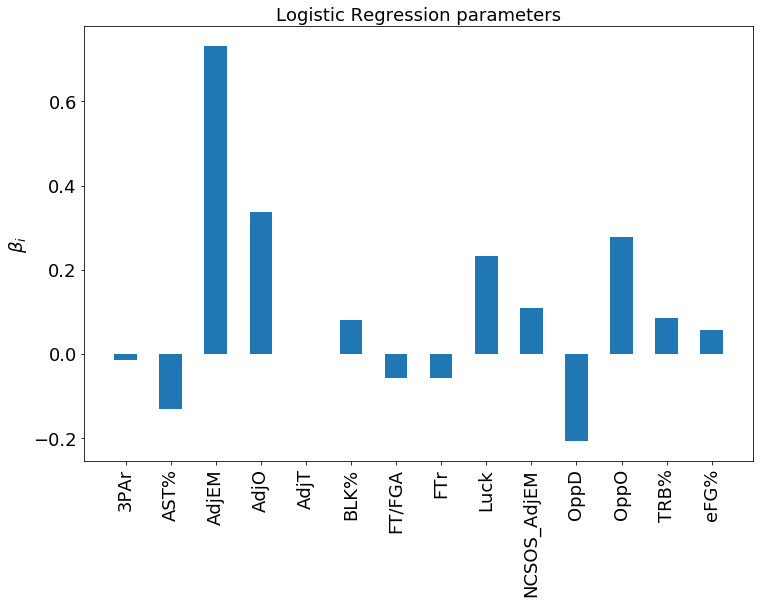

In [61]:
ndata=int(len(model.coef_[0]))
plt.bar(np.arange(ndata), model.coef_[0],width=0.5)
# plt.bar(np.arange(ndata)+.15, -model.coef_[0][ndata:],width=0.3)
labels=dfClean.keys();
plt.xticks(np.arange(ndata), labels, rotation='vertical');
plt.gca().tick_params(labelsize=18)
plt.title('Logistic Regression parameters',size=18);
plt.ylabel('$\\beta_i$',size=18);

# plt.x

# Show logistic regression plot

In [35]:
def logit(x):
    return 1./(1.+np.exp(-x))
# logit(X_test.dot(model.coef_.T)).values-model.predict_proba(X_test)[:,1,None]

In [41]:
X_test.shape

(353, 18)

(-5, 5)

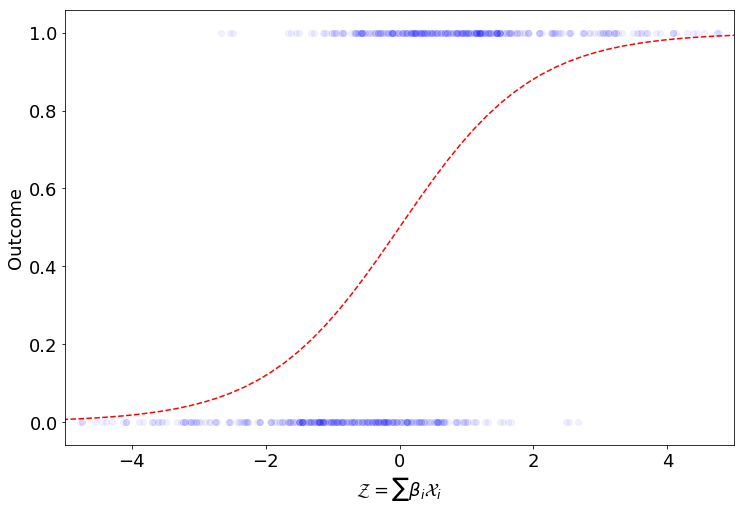

In [39]:
xcoord = X_test.dot(model.coef_.T)
plt.scatter(xcoord, y_test,color=[0,0,1,.05])
plt.scatter(-xcoord, 1-y_test,color=[0,0,1,.05])
plt.xlabel('${\cal Z}=\sum \\beta_i {\cal X}_i$',size=18)
plt.ylabel('Outcome',size=18)
plt.gca().tick_params(labelsize=18)

x=np.linspace(-10,10,100)
plt.plot(x,logit(x),'r--')
plt.xlim(-5,5)

## Confusion Matrix


In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
confusion_matrix(y_test,np.round(y_predPythag))

ValueError: Found input variables with inconsistent numbers of samples: [221, 265]

In [29]:

confusion_matrix(y_test,y_pred)

array([[ 43,  37],
       [ 23, 118]])

In [165]:
rf=RandomForestClassifier(n_estimators=100, oob_score=True, random_state=123456)
rf.fit(X_train,y_train)
pred=rf.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,pred)

0.75113122171945701

In [166]:
resDF.plot(x='Log reg',y='Pythag',kind='scatter')
plt.xlim(0,1)
plt.ylim(0,1)

NameError: name 'resDF' is not defined

# Test with teams split by k-means and PCA

In [107]:
resultList=[]
for yr in np.arange(2017,2003,-1):
    year=str(yr)
    teamType=pd.read_csv('data/team_type_'+year+'.csv')
    teamTypeDict={}
    for r in teamType.values:
        teamTypeDict[r[0]]=r[1]

    df=pd.read_csv('data/games/all_games_'+year+'.csv',index_col=0).dropna(axis=1)
    # df=pd.read_csv('data/games/tourn_games_2016.csv',index_col=0)
    # y=df['outcome']
    dropLabels=['School_1','Conf_1','wpct_1','Rank_1','WL_1','sched_url_1',\
                'School_2','Conf_2','wpct_2','Rank_2','WL_2','sched_url_2', 'outcome']

    y=df['outcome']


    types=[]
    for r in df.itertuples():

        t1=teamTypeDict[r.School_1]
        t2=teamTypeDict[r.School_2]

        types.append(str(min(t1,t2))+str(max(t1,t2)))

    df['types']=types

    runsum=0
    numsum=0
    pythsum=0

    nlab=3
    for t1lab in range(nlab):
        for t2lab in np.arange(t1lab,nlab):
            lab = str(t1lab)+str(t2lab)

            dfSel = df[(df.types==lab)]
            dropLabels.append('types')

            X=dfSel.drop(dropLabels,axis=1)
            y=dfSel['outcome']


            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
            logreg = LogisticRegression()
            logreg.fit(X_train, y_train)

            y_pred=logreg.predict(X_test)
            print(lab,len(y_pred))
            print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


            y_predPythag=pythagGame(X_test)

            print('Accuracy using pythagorean win expectation: ',(np.round(y_predPythag)==y_test).sum()/len(y_test))


            kfold = model_selection.KFold(n_splits=10, random_state=7)
            modelCV = LogisticRegression()
            scoring = 'accuracy'
            results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
            print("10-fold cross validation average accuracy: %.3f" % (results.mean()))    

            runsum+= len(y_pred) * results.mean() #logreg.score(X_test, y_test)
            numsum+= len(y_pred)
            pythsum+= len(y_pred) *(np.round(y_predPythag)==y_test).sum()/len(y_test)



    print ()
    print (runsum/numsum)
    print (pythsum/numsum)
    
    resultList.append([year,(runsum/numsum),pythsum/numsum])
    
resDFKM=pd.DataFrame(resultList,columns=['year','Log reg','Pythag'])


00 613
Accuracy of logistic regression classifier on test set: 0.67
Accuracy using pythagorean win expectation:  0.68515497553
10-fold cross validation average accuracy: 0.669
01 281
Accuracy of logistic regression classifier on test set: 0.84
Accuracy using pythagorean win expectation:  0.79359430605
10-fold cross validation average accuracy: 0.830
02 940
Accuracy of logistic regression classifier on test set: 0.77
Accuracy using pythagorean win expectation:  0.76170212766
10-fold cross validation average accuracy: 0.754
11 388
Accuracy of logistic regression classifier on test set: 0.65
Accuracy using pythagorean win expectation:  0.682989690722
10-fold cross validation average accuracy: 0.669
12 287
Accuracy of logistic regression classifier on test set: 0.92
Accuracy using pythagorean win expectation:  0.91637630662
10-fold cross validation average accuracy: 0.922
22 530
Accuracy of logistic regression classifier on test set: 0.70
Accuracy using pythagorean win expectation:  0.6943

10-fold cross validation average accuracy: 0.627
12 638
Accuracy of logistic regression classifier on test set: 0.82
Accuracy using pythagorean win expectation:  0.815047021944
10-fold cross validation average accuracy: 0.799
22 674
Accuracy of logistic regression classifier on test set: 0.68
Accuracy using pythagorean win expectation:  0.695845697329
10-fold cross validation average accuracy: 0.650

0.734948243054
0.771009174312
00 612
Accuracy of logistic regression classifier on test set: 0.64
Accuracy using pythagorean win expectation:  0.62091503268
10-fold cross validation average accuracy: 0.644
01 431
Accuracy of logistic regression classifier on test set: 0.88
Accuracy using pythagorean win expectation:  0.867749419954
10-fold cross validation average accuracy: 0.845
02 646
Accuracy of logistic regression classifier on test set: 0.77
Accuracy using pythagorean win expectation:  0.78173374613
10-fold cross validation average accuracy: 0.764
11 406
Accuracy of logistic regressio

In [109]:
resDFKM.mean()

year       1.440858e+54
Log reg    7.391709e-01
Pythag     7.464952e-01
dtype: float64

In [116]:

kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.578


In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
# logreg = LogisticRegression(C=1,penalty='l1',tol=0.1)
logreg.fit(X_train, y_train)
y_pred=logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))


Accuracy of logistic regression classifier on test set: 0.70


In [11]:
df['pythag']=pythagGame(df)

In [15]:
y_predPythag=pythagGame(X_test)

print('Accuracy using pythagorean win expectation: ',(np.round(y_predPythag)==y_test).sum()/len(y_test))
# print(len(y_test))

Accuracy using pythagorean win expectation:  0.739459815547
